In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https:// ### ADD GIT TOKEN ### @github.com/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
#!git checkout kh-update-evaluation-metrics
!pip install .
!pip install -r requirements.txt > /dev/null
%cd gizmo
!pip install -e .

Cloning into 'teamBlueConduit'...
remote: Enumerating objects: 768, done.
remote: Counting objects: 100% (768/768), done.
remote: Compressing objects: 100% (537/537), done.
remote: Total 768 (delta 380), reused 542 (delta 210), pack-reused 0
Receiving objects: 100% (768/768), 57.44 MiB | 23.79 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/teamBlueConduit
Processing /content/teamBlueConduit
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for BlueConduitSpatial: filename=BlueConduitSpatial-0.0.0-py3-none-any.whl size=66705 sha256=2b9eb3d6eb15c448383c91663b657d5b296f75270835b672c9c8f74f5dc131d4
  Stored in directory

In [ ]:
from blue_conduit_spatial.utilities import *

In [ ]:
!ls '/content/drive/MyDrive/AC297r/Data'
data_dir = '/content/drive/MyDrive/AC297r/Data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, pid, train_idx, test_idx, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir)

Predictions  Processed	Raw


In [ ]:
from blue_conduit_spatial.evaluation import *
import numpy as np

## Demo of new `select_data` method"

In [ ]:
hex_size = 47
train_size = 0.1
split = 0

(train_index, test_index, 
 Xtrain, Xtest, Ytrain, Ytest, 
 train_pred, test_pred, hexagons) = select_data(Xdata, 
                                                Ydata, 
                                                pid, 
                                                train_idx, 
                                                test_idx, 
                                                train_pred_all, 
                                                test_pred_all,
                                                partitions_builder, 
                                                train_size=train_size,
                                                n_hexagons=hex_size,
                                                split=split)

2021-11-03 03:13.57 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23272.15it/s]

2021-11-03 03:13.59 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-03 03:13.59 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-03 03:14.01 [debug    ] Total parcels after join: 26857
2021-11-03 03:14.02 [info     ] Building the connected graph on the partitions.
2021-11-03 03:14.05 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


In [ ]:
Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape

((2354, 301), (19293, 301), (2354,), (19293,))

In [ ]:
## Load data
#hex_size = 47
#train_size = 'ts_0.1'
#resolution = f'res_{hex_size}'
#split = 0
#
#train_index = train_idx[train_size][resolution][split].values
#test_index = test_idx[train_size][resolution][split].values
#
#Xtrain = Xdata.iloc[train_index]
#Xtest = Xdata.iloc[test_index]
#Ytrain = Ydata.iloc[train_index]['dangerous'].values.astype('float')
#Ytest = Ydata.iloc[test_index]['dangerous'].values.astype('float')
#train_pred = train_pred_all[train_size][resolution][split]
#test_pred = test_pred_all[train_size][resolution][split]
#pid_train = pid.iloc[train_index].pid.values
#pid_test = pid.iloc[test_index].pid.values
#pid_lat_lon_train = pid.iloc[train_index]
#pid_lat_lon_test = pid.iloc[test_index]
#
#
#
#hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)
#
#Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape, pid_train.shape, pid_test.shape

In [ ]:
threshold_orig = 0.9
threshold_increment_size = 0.1
N_lim = 5
N_lim_increment_size = 1

In [ ]:
#def generate_hit_rate_curve_by_partition(parcel_df, 
#                                        index_list, 
#                                        y_true, 
#                                        y_pred, 
#                                        threshold_init, 
#                                        threshold_increment=0.1, 
#                                        min_digs=5, 
#                                        min_digs_increment=5
#                                        ):
#    """Generates a hit rate curve where parcels are investigated partition. 
#    
#    Made to be inter-operable with the `gizmo` partitioning. Agnostic to shape 
#    of the partition, but must pass a parcel df which contains a parcel ID. Can 
#    replicate initial analyses by passing an ordered DF with 
#    'partition_ID' = 'PRECINCT'.
#    
#    Args:
#        parcel_df: Ordered dataframe passing reference to pid and partition_ID
#        index_list: Array-like list of indices in the i.e. test set (as used 
#          to divide train/test data)
#        y_true: True values (should be in order of `index_list`). Sk-learn API.
#        y_pred: Prediction probabilities at the parcel-level; SK-Learn API. 
#        threshold_init: Initial threshold for decision-making.
#        threshold_increment: Float to decrease threshold by at each iteration.
#        min_digs: Minimum number of digs required in a partition to visit.
#
#    Returns:
#        hit_rates: Cumulative hit rates for ordered test set
#        pred_probs: Predicted probabilities for ordered test set
#    """
#    # Create temporary dataframe containing only necessary features for filtering
#    # process (initial parcel_df has many features; done to save space)
#    df = parcel_df.iloc[index_list]
#    df['pred_prob'] = y_pred.copy()
#    df['true_val'] = y_true.copy()
#    df = df[['partition_ID', 'pred_prob', 'true_val']]
#    threshold = threshold_init
#
#    # Create running list of true values and prediction probs
#    true_label_list = []
#    pred_prob_list = []
#
#    # Also track indices that have been dug
#    part_dug_idx_list = []
#
#    # Continue to move through DF while some parcels have not been added
#    while len(df) > 0:
#        # Find total parcels in each partition which have > threshold pred prob
#        df['dig'] = (df['pred_prob'] > threshold).astype(int)
#        part_sort = df.groupby(
#            'partition_ID').sum()['dig'].sort_values(ascending=False)
#        
#        for i, x in enumerate(part_sort):
#            # If fewer than `min_digs` expected hits in a given partition, 
#            # break out of loop (sorting enforces that partition n+1 will
#            # have <= x expected hits)
#            if x < min_digs:
#                break
#            else:
#                part_idx = part_sort.index[i]
#                # Within a partition, order by the prediction probability
#                # Simulates prioritizing specific parcels within a partition, but could
#                # also choose some sort of random / noisy optimization as well
#                to_dig = df[(df['partition_ID']==part_idx) & (df['dig']==1)].sort_values(
#                    'pred_prob', ascending=False)
#
#                true_label_list.extend(to_dig['true_val'].values)
#                part_dug_idx_list.extend(to_dig.index.values)
#                pred_prob_list.extend(to_dig['pred_prob'].values)
#        
#
#        # Remove all parcels which have been excavated from the
#        df = df.iloc[~df.index.isin(part_dug_idx_list)]
#
#        # If possible, decrease threshold
#        if threshold - threshold_increment > 0:
#          threshold -= threshold_increment
#        else:
#          min_digs -= min_digs_increment
#          threshold = threshold_init
#
#    return np.cumsum(true_label_list)/(np.arange(len(true_label_list))+1), pred_prob_list

2021-11-03 03:20.43 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23714.53it/s]

2021-11-03 03:20.45 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-03 03:20.45 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-03 03:20.47 [debug    ] Total parcels after join: 26857
2021-11-03 03:20.48 [info     ] Building the connected graph on the partitions.
2021-11-03 03:20.51 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


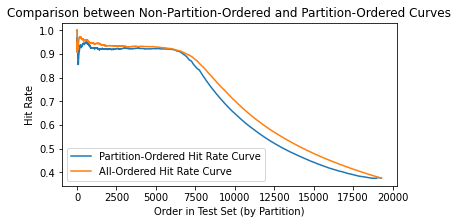

In [ ]:
import matplotlib.pyplot as plt
from blue_conduit_spatial.evaluation import generate_hit_rate_curve
for s in range(3):
  (train_index, test_index, Xtrain, Xtest, 
   Ytrain, Ytest, 
   train_pred, test_pred, hexagons) = select_data(Xdata, 
                                                  Ydata, 
                                                  pid, 
                                                  train_idx, 
                                                  test_idx, 
                                                  train_pred_all, 
                                                  test_pred_all,
                                                  partitions_builder, 
                                                  train_size=train_size,
                                                  n_hexagons=hex_size,
                                                  split=s)

  hrc = generate_hit_rate_curve_by_partition(hexagons.parcel_gdf, 
                                                      test_index, 
                                                      Ytest,
                                                      test_pred, 
                                                      threshold_init=threshold_orig)
  hrc_orig = generate_hit_rate_curve(Ytest, test_pred)
  fig = plt.figure(figsize=(6,3))
  plt.plot(hrc[0], label='Partition-Ordered Hit Rate Curve')
  plt.plot(hrc_orig[0], label='All-Ordered Hit Rate Curve')
  plt.ylabel("Hit Rate")
  plt.xlabel(f"Order in Test Set (by Partition)")
  plt.title(f"Comparison between Non-Partition-Ordered and Partition-Ordered Curves")
  plt.legend()
  plt.show()
  break

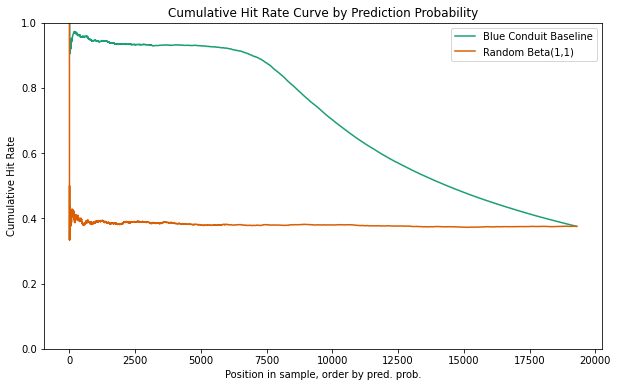

In [ ]:
plot_hit_rate_curve(Ytest, [test_pred, np.random.beta(1, 1, size=len(test_pred))], plot_probs=False, labels=['Blue Conduit Baseline', 'Random Beta(1,1)'], mode='all')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/blue_conduit_spatial/evaluation/evaluate.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dig'] = (df['pred_prob'] > threshold).astype(int)


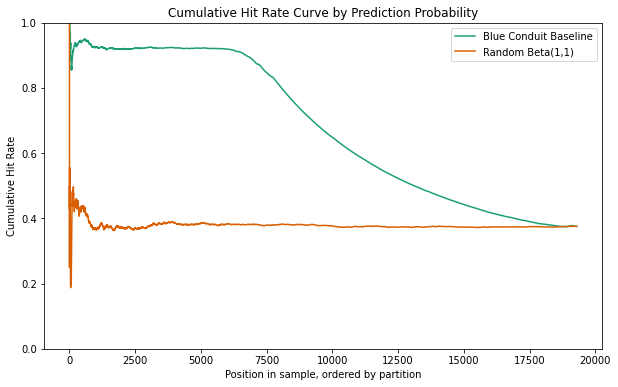

In [ ]:
plot_hit_rate_curve(Ytest, [test_pred, np.random.beta(1, 1, size=len(test_pred))], plot_probs=False, labels=['Blue Conduit Baseline', 'Random Beta(1,1)'], mode='partition', 
                    parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=threshold_orig)